<a href="https://colab.research.google.com/github/dimitramuni/GBN-Regime-in-Basketball/blob/main/XGBoost_SHAP_Analysis_Chicago_Bulls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap -q

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb

#SHAP package
import shap
shap.initjs()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#df=pd.read_csv('/content/drive/MyDrive/GBN-Regime-in-Basketball/data/PreProcessed_Chicago_Gamelog.csv')

In [ ]:
df_basic=pd.read_csv('/content/drive/MyDrive/GBN-Regime-in-Basketball/data/Chicago_basic_gamelog_8384_2021.csv')
df_advanced=pd.read_csv('/content/drive/MyDrive/GBN-Regime-in-Basketball/data/Chicago_advanced_gamelog_8384_2021.csv')

In [ ]:
df=df_basic.merge(df_advanced,on=['Date','Sep','Opp','WL','TmScore','OppScore'])
df.columns

Index(['Date', 'Sep', 'Opp', 'WL', 'TmScore', 'OppScore', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1',
       'FT.1', 'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1',
       'TOV.1', 'PF.1', 'ORtg', 'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'eFG%.1',
       'TOV%.1', 'DRB%', 'FT/FGA.1'],
      dtype='object')

In [ ]:
df.columns=['Date', 'Sep', 'Opp', 'WL','TmScore','OppScore', 'FG', 'FGA', 'FGPer', 'Tm3P',
                'Tm3PA', 'Tm3PPer', 'TmFT', 'TmFTA', 'TmFTPer', 'TmORB', 'TmTRB', 'TmAST', 'TmSTL', 'TmBLK',
                'TmTOV', 'TmPF', 'OppFG', 'OppFGA', 'OppFGPer', 'Opp3P', 'Opp3PA', 'Opp3PPer', 'OppFT',
                'OppFTA', 'OppFTPer', 'OppORB', 'OppTRB', 'OppAST', 'OppSTL', 'OppBLK', 'OppTOV',
                'OppPF','ORtg', 'DRtg', 'Pace', 'FTr', 'Tm3PAr', 'TSPer', 'TRBPer',
                'ASTPer', 'STLPer', 'BLKPer', 'TmeFGPer', 'TmTOVPer', 'ORBPer', 'TmFT_d_FGA', 'OppeFGPer',
                'OppTOVPer', 'DRBPer', 'OppFT_d_FGA']

In [ ]:
df['Home']=np.where(df['Sep']=='@',False,True)
df['WL']=np.where(df['WL']=='W',True,False)
df=df.drop(columns=['Sep','OppFG', 'OppFGA', 'OppFGPer', 'Opp3P', 'Opp3PA', 'Opp3PPer', 'OppFT',
                'OppFTA', 'OppFTPer', 'OppORB', 'OppTRB', 'OppAST', 'OppSTL', 'OppBLK', 'OppTOV',
                'OppPF'])


In [ ]:
#df[['Tm3PPer','Opp3PPer']]=df[['Tm3PPer','Opp3PPer']].fillna(0)
df[['Tm3PPer']]=df[['Tm3PPer']].fillna(0)

In [ ]:
df.columns[df.isna().any()]

Index([], dtype='object')

In [ ]:
df.shape

(3041, 40)

In [ ]:
df=df.dropna()

In [ ]:
df.columns

Index(['Date', 'Opp', 'WL', 'TmScore', 'OppScore', 'FG', 'FGA', 'FGPer',
       'Tm3P', 'Tm3PA', 'Tm3PPer', 'TmFT', 'TmFTA', 'TmFTPer', 'TmORB',
       'TmTRB', 'TmAST', 'TmSTL', 'TmBLK', 'TmTOV', 'TmPF', 'ORtg', 'DRtg',
       'Pace', 'FTr', 'Tm3PAr', 'TSPer', 'TRBPer', 'ASTPer', 'STLPer',
       'BLKPer', 'TmeFGPer', 'TmTOVPer', 'ORBPer', 'TmFT_d_FGA', 'OppeFGPer',
       'OppTOVPer', 'DRBPer', 'OppFT_d_FGA', 'Home'],
      dtype='object')

In [ ]:
df.shape

(3041, 40)

# Feature Augmentation


## PlayOff Appearance of the Opponent team in a the Season

In [ ]:
preprocessed_data_R=pd.read_csv('/content/drive/MyDrive/GBN-Regime-in-Basketball/data/PreProcessed_Chicago_Gamelog.csv')

In [ ]:
df['Opponent_PlayOff']=preprocessed_data_R['PlayOff']

## Player WinShare

In [ ]:
players_ws=pd.read_csv('/content/drive/MyDrive/GBN-Regime-in-Basketball/data/All_Season_Players_WS48.csv')
df=df.merge(players_ws,on=['Date','Opp'])

## Number of Wins in Last 15, 10 and 5 games

In [ ]:
df['WinsInLast15']=df['WL'].rolling(15,min_periods=1,center=False).sum()
df['WinsInLast10']=df['WL'].rolling(10,min_periods=1,center=False).sum()
df['WinsInLast5']=df['WL'].rolling(5,min_periods=1,center=False).sum()

## Consecutive games

In [ ]:
df['Date']=pd.to_datetime(df['Date'])

In [ ]:
df['Date'].head()

0   1983-10-29
1   1983-11-01
2   1983-11-03
3   1983-11-04
4   1983-11-08
Name: Date, dtype: datetime64[ns]

In [ ]:
df['days_between_games']=[0]+[(df['Date'].iloc[i]-df['Date'].iloc[i-1]).days for i in range(1,df['Date'].shape[0])]


# Rolling Average of ORtg and DRtg


# $\delta_{20}^{Rtg}=\mu_{20}^{ORtg}$-$\mu_{20}^{DRtg}$





# Rolling Average of TmScore and OppScore

Text(0, 0.5, 'score')

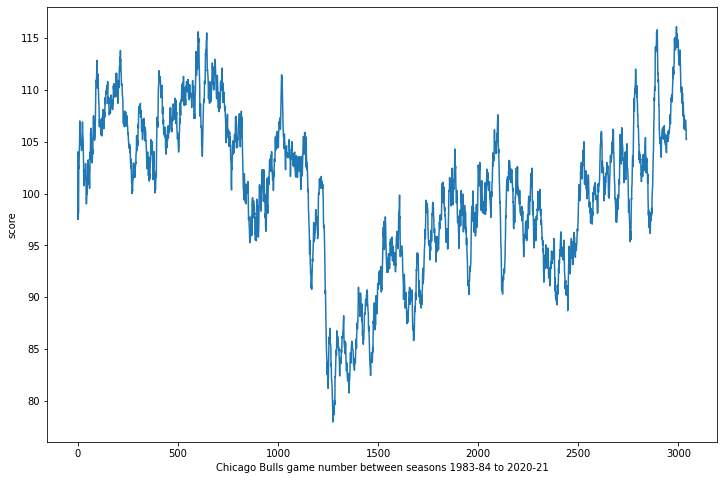

In [ ]:
roll_window_len=20
df['TmScore_rolling_mean']=df['TmScore'].rolling(roll_window_len,min_periods=1,center=False).mean()
plt.figure(figsize=[12,8])
plt.plot(df['TmScore_rolling_mean'])
plt.xlabel('Chicago Bulls game number between seasons 1983-84 to 2020-21')
plt.ylabel('score')

Text(0, 0.5, 'score')

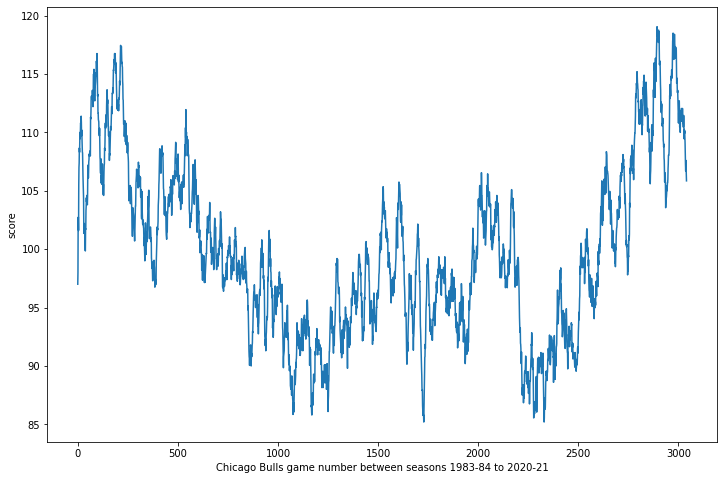

In [ ]:
df['OppScore_rolling_mean']=df['OppScore'].rolling(roll_window_len,min_periods=1,center=False).mean()
plt.figure(figsize=[12,8])
plt.plot(df['OppScore_rolling_mean'])
plt.xlabel('Chicago Bulls game number between seasons 1983-84 to 2020-21')
plt.ylabel('score')

# Polynomial Regressor 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

Text(0, 0.5, 'Score Difference')

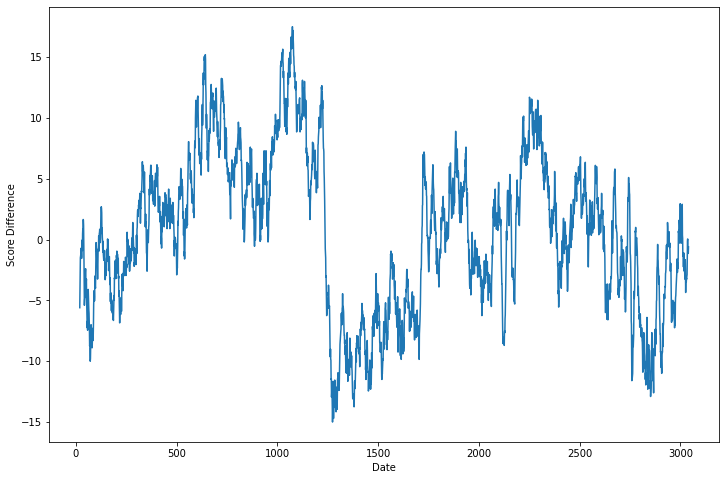

In [ ]:
s=df['TmScore_rolling_mean']-df['OppScore_rolling_mean']
#s=df['ORtg_rolling_mean']-df['DRtg_rolling_mean']
plt.figure(figsize=[12,8])
plt.plot(s[roll_window_len:])
plt.xlabel('Date')
plt.ylabel('Score Difference')

# **XGBoost**

In [ ]:

df['Team_Prospect']=s
df.to_csv('Augmented_Chicago_Bulls_8384_2021.csv',index=False)

Text(0, 0.5, 'Score Difference')

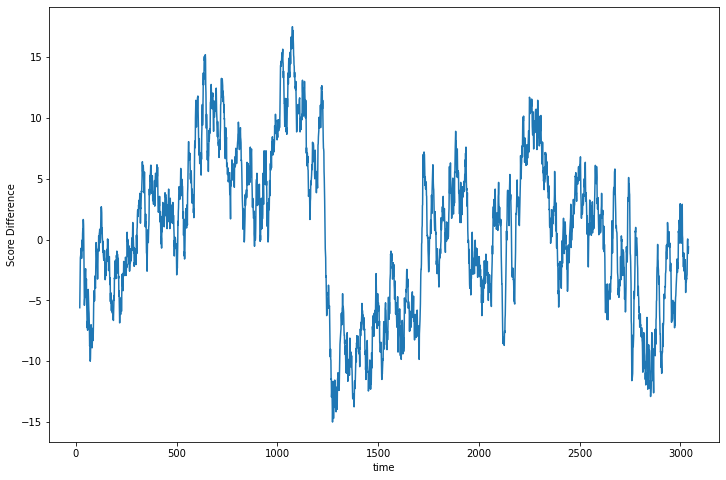

In [ ]:
plt.figure(figsize=[12,8])
plt.plot(s[roll_window_len:])
plt.xlabel('time')
plt.ylabel('Score Difference')

In [ ]:
X_df=df.iloc[20:,3:].drop(columns=['TmScore','OppScore','Team_Prospect','TmScore_rolling_mean','OppScore_rolling_mean',])
y_df=df['Team_Prospect'][20:]
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X_df,y_df,random_state=1729)

In [ ]:
mtrain=xgb.DMatrix(Xtrain,label=Ytrain)
mvalidation=xgb.DMatrix(Xtest,label=Ytest)

    

In [ ]:
baseline=np.mean(Ytrain)

In [ ]:
params={'max_depth': 10, 
        'eta': 0.1, 
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'base_score': baseline,
        'SEED': 1728}

In [ ]:
%time
model=xgb.train(params=params,
                dtrain=mtrain,
                num_boost_round=2000,
                early_stopping_rounds=15,
                evals=[(mtrain,'training'),(mvalidation,'validation')])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
[0]	training-rmse:5.74269	validation-rmse:6.0316
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 15 rounds.
[1]	training-rmse:5.2265	validation-rmse:5.54163
[2]	training-rmse:4.76097	validation-rmse:5.11469
[3]	training-rmse:4.34006	validation-rmse:4.74116
[4]	training-rmse:3.96109	validation-rmse:4.41853
[5]	training-rmse:3.61848	validation-rmse:4.13037
[6]	training-rmse:3.30889	validation-rmse:3.88488
[7]	training-rmse:3.02861	validation-rmse:3.66789
[8]	training-rmse:2.77434	validation-rmse:3.4743
[9]	training-rmse:2.54401	validation-rmse:3.31024
[10]	training-rmse:2.33505	validation-rmse:3.17704
[11]	training-rmse:2.14765	validation-rmse:3.05557
[12]	training-rmse:1.97578	validation-rmse:2.9487
[13]	training-rmse:1.81943	validation-rmse:2.85324
[14]	training-rmse:1.67799	validation-rmse:2.77264
[15]	training-rmse:1.54663	val

In [ ]:
%%time
explainer=shap.TreeExplainer(model=model,feature_perturbation='interventional')
shap_values=explainer.shap_values(X_df,check_additivity=False )

CPU times: user 1min 15s, sys: 94.7 ms, total: 1min 15s
Wall time: 39.5 s


In [ ]:
X_df.shape

(3021, 43)

In [ ]:
X_df.columns

Index(['FG', 'FGA', 'FGPer', 'Tm3P', 'Tm3PA', 'Tm3PPer', 'TmFT', 'TmFTA',
       'TmFTPer', 'TmORB', 'TmTRB', 'TmAST', 'TmSTL', 'TmBLK', 'TmTOV', 'TmPF',
       'ORtg', 'DRtg', 'Pace', 'FTr', 'Tm3PAr', 'TSPer', 'TRBPer', 'ASTPer',
       'STLPer', 'BLKPer', 'TmeFGPer', 'TmTOVPer', 'ORBPer', 'TmFT_d_FGA',
       'OppeFGPer', 'OppTOVPer', 'DRBPer', 'OppFT_d_FGA', 'Home',
       'Opponent_PlayOff', 'Continuing_Players_WS', 'Leaving_Players_WS',
       'Incoming_Players_WS', 'WinsInLast15', 'WinsInLast10', 'WinsInLast5',
       'days_between_games'],
      dtype='object')

In [ ]:
explainer.expected_value

0.53270084

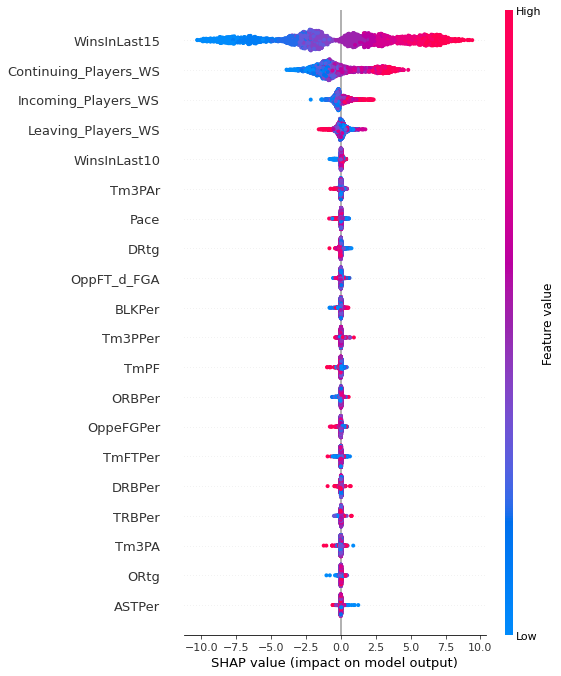

In [ ]:
shap.summary_plot(shap_values,X_df)